<a href="https://colab.research.google.com/github/Akanerd/ComputerVision-Orbit/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
(x_train, _),(x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
                                        layers.Flatten(),
                                        layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(784, activation='sigmoid'),
                                        layers.Reshape((28,28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
from sklearn.utils import shuffle
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.0239 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.008

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

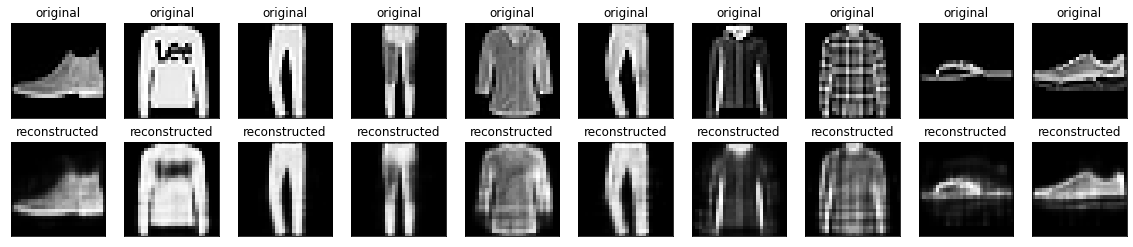

In [ ]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  #Original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  #Reconstruction
  ax  = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Autoencoder Denoising

In [ ]:
(x_train, _),(x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Add noise to dataset

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.,clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.,clip_value_max=1.)

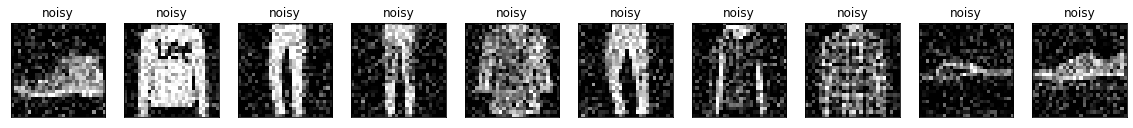

In [ ]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
  #Original
  ax = plt.subplot(1, n, i+1)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title("noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Input(shape=(28,28,1)),
                                        layers.Conv2D(16,(3,3),activation='relu',padding='same', strides=2),
                                        layers.Conv2D(8,(3,3),activation='relu',padding='same', strides=2)
    ])

    self.decoder = tf.keras.Sequential([
                                        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                                        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                                        layers.Conv2D(1,kernel_size=(3,3), activation='sigmoid', padding='same')
    ])
  
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=15,
                shuffle=True,
                validation_data=(x_test_noisy,x_test))

Epoch 1/15
1875/1875 [==============================] - 22s 7ms/step - loss: 0.0161 - val_loss: 0.0099
Epoch 2/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 3/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 4/15
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 5/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 6/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 7/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/15
1875/1875 [==============================] - 11s 6ms/step - l

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

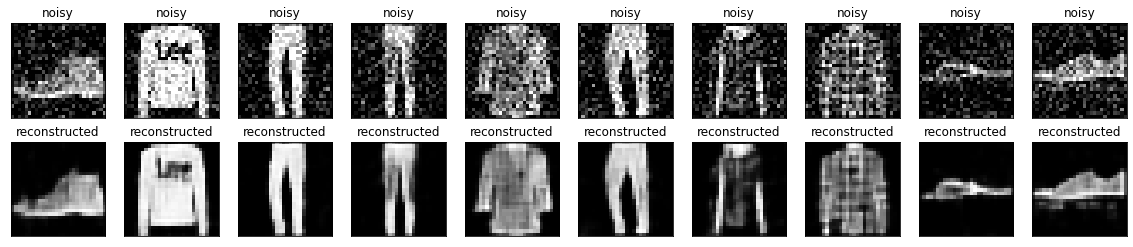

In [ ]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  #Original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title("noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  #Reconstruction
  ax  = plt.subplot(2, n, i+n+1)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Variational Autoencoder

In [ ]:
!pip install tensorflow-probability

!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-lz4lcqjy
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-lz4lcqjy
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=178325 sha256=ead2f6e3aa45dcd5857f172c33cc39c989af861a3e3080b7e1cd08291a340471
  Stored in directory: /tmp/pip-ephem-wheel-cache-51er41wo/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def preprocess(images):
  images=images.reshape((images.shape[0],28,28,1))/255.
  return np.where(images>.5,1.0,0.0).astype('float32')

train_images = preprocess(train_images)
test_images = preprocess(test_images)

In [ ]:
train_size = 60000
batch_size = 12
test_size = 10000

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(train_size).batch(batch_size))

Network Architecture

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional Variational Autoencoder"""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
                                        tf.keras.layers.InputLayer(input_shape=(28,28,1)),
                                        tf.keras.layers.Conv2D(
                                            filters=32,kernel_size=3,strides=(2,2),activation='relu'
                                        ),
                                        tf.keras.layers.Conv2D(
                                            filters=64,kernel_size=3,strides=(2,2),activation='relu'
                                        ),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(latent_dim+latent_dim)
    ])

    self.decoder = tf.keras.Sequential([
                                        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                                        tf.keras.layers.Reshape(target_shape=(7,7,32)),
                                        tf.keras.layers.Conv2DTranspose(
                                            filters=64,kernel_size=3,strides=2,padding='same',activation='relu'
                                        ),
                                        tf.keras.layers.Conv2DTranspose(
                                            filters=32,kernel_size=3,strides=2,padding='same',activation='relu'
                                        ),
                                        tf.keras.layers.Conv2DTranspose(
                                            filters=1,kernel_size=3,strides=1,padding='same'
                                        ),
    ])
  @tf.function
  def sample(self,eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps,apply_sigmoid=True)
  
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean,logvar
  
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps*tf.exp(logvar*.5)+mean
  
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs=tf.sigmoid(logits)
      return probs
    return logits

Define Loss Function

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5*((sample-mean)**2. * tf.exp(-logvar)+logvar+log2pi),axis=raxis
  )

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z=model.reparametrize(mean,logvar)
  x_logit=model.decode(z)
  cross_ent=tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit,labels =x)
  logpx_z=-tf.reduce_sum(cross_ent, axis=[1,2,3])
  logpz = log_normal_pdf(z, 0. ,0.)
  logqz_x = log_normal_pdf(z ,mean, logvar)
  return -tf.reduce_mean(logpx_z+logpz-logqz_x)

@tf.function

def train_step(model, x, optimizer):